In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Add, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
tf.Tensor(728.558, shape=(), dtype=float32)
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-11 22:45:41.221752: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 22:45:41.638986: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38420 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


## VNet Implementation
> https://arxiv.org/pdf/1606.04797.pdf

In [4]:
def conv_block(input_tensor, num_filters):
    shortcut = Conv3D(num_filters, (1,1,1), padding='same')(input_tensor) # skip connection added for residual connection
    x = Conv3D(num_filters, (3,3,3), padding='same')(input_tensor)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Conv3D(num_filters, (3,3,3), padding='same')(x)
    x = Activation('relu')(x)
    return Add()([x, shortcut]) # residual connection as per the VNET paper64

In [5]:
def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = MaxPooling3D((2,2,2))(x)
    p = Dropout(0.5)(p)
    return x, p

In [6]:
def decoder_block(input_tensor, concat_tensor, num_filters):
    x = UpSampling3D((2,2,2))(input_tensor)
    x = Conv3D(num_filters, (1,1,1))(x) # 1X1X1 convolution operation to match the filters
    x = Add()([x, concat_tensor]) # skip connection implementation. VNET is a variant of UNET.
    x = conv_block(x, num_filters)
    return x

In [7]:
def vnet_regression(input_shape):
    inputs = Input(input_shape)
    
    e0, p0 = encoder_block(inputs, 16)
    e1, p1 = encoder_block(p0, 32)
    e2, p2 = encoder_block(p1, 64)
    e3, p3 = encoder_block(p2, 128)
    
    b0 = conv_block(p3, 256)
    
    d3 = decoder_block(b0, e3, 128)
    d2 = decoder_block(d3, e2, 64)
    d1 = decoder_block(d2, e1, 32)
    d0 = decoder_block(d1, e0, 16)
    
    outputs = Conv3D(1, (1,1,1), activation='linear')(d0)
    
    model = Model(inputs=[inputs], outputs=[outputs], name="vnet_regression")
    
    return model

------

In [8]:
# import sys
# import numpy as np

# sys.path.insert(0, './src')

# from generate_data import get_simulated_data

In [9]:
# Assuming the same get_simulated_data function
# data = get_simulated_data(n_simulations=50000, 
#                           power_spectrum_file_location='./generated_data/pk_my_cosmo.txt', )

In [10]:
# data = np.array(data)
# np.save('simulated_data_110124_50K.npy', data)

In [11]:
data = np.load('./generated_data/simulated_data_020124_150K.npy')

--------

In [12]:
os.environ['PYTHONHASHSEED']=str(123)

np.random.seed(123)
tf.random.set_seed(123)

In [13]:
# Split the data
initial_state = data[:, 0]
final_state = data[:, 1]

# Compute the mean and std of the initial and final states
initial_state_mean, initial_state_std = np.mean(initial_state), np.std(initial_state)
final_state_mean, final_state_std = np.mean(final_state), np.std(final_state)

# Normalize the initial and final states
initial_state = (initial_state - initial_state_mean) / initial_state_std
final_state = (final_state - final_state_mean) / final_state_std

# Select one simulation's initial and final states
initial_conditions = initial_state[0]
final_density = final_state[0]

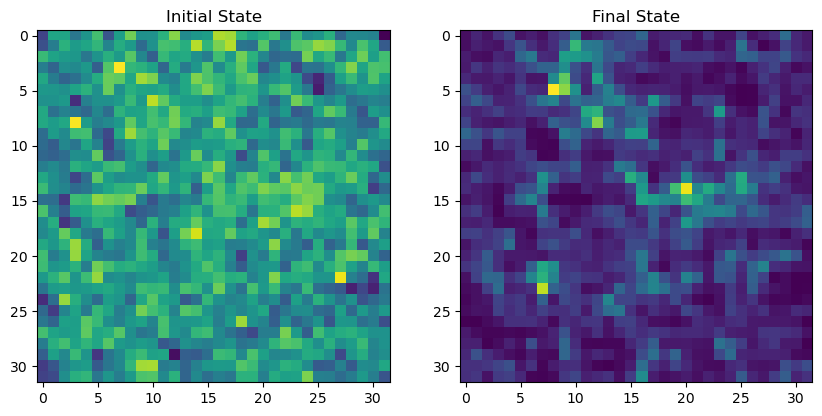

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# initial state and final state
axes[0].imshow(initial_conditions[0], cmap='viridis')
axes[0].set_title("Initial State")

axes[1].imshow(final_density[0], cmap='viridis')  
axes[1].set_title("Final State")

plt.show()

In [15]:
# train and test
X_train, X_test, y_train, y_test  = train_test_split(initial_state, final_state, test_size=0.15, random_state=123)

# further splitting it in training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=123)

In [16]:
# Recasting dimensions to 4D tensor (suitable for 3D convolutions) with the following dimensions: (batch_size, height, width, depth, num_channels)
X_train = np.reshape(X_train, (*X_train.shape, 1))
X_val = np.reshape(X_val, (*X_val.shape, 1))
X_test = np.reshape(X_test, (*X_test.shape, 1))

y_train = np.reshape(y_train, (*y_train.shape, 1))
y_val = np.reshape(y_val, (*y_val.shape, 1))
y_test = np.reshape(y_test, (*y_test.shape, 1))

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((108375, 32, 32, 32, 1),
 (108375, 32, 32, 32, 1),
 (19125, 32, 32, 32, 1),
 (19125, 32, 32, 32, 1),
 (22500, 32, 32, 32, 1),
 (22500, 32, 32, 32, 1))

------
# VNET

In [17]:
# Parameters
Ngrid = 32  # grid size

In [18]:
vnet_model = vnet_regression((Ngrid, Ngrid, Ngrid, 1))

In [19]:
# Compile the model
vnet_model.compile(optimizer=Adam(), 
                   loss='mse',
                   metrics=['mae'],
                   run_eagerly=True)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=5, 
                              min_lr=0.001)
checkpoint = ModelCheckpoint('vnet_150K_110124.hdf5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True)

In [21]:
history = vnet_model.fit(x=X_train, 
                         y=y_train, 
                         validation_data=(X_val, y_val), 
                         batch_size=32, 
                         epochs=50, 
                         callbacks=[early_stopping, reduce_lr, checkpoint])

Epoch 1/50


2024-01-11 21:40:51.409627: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-01-11 21:40:59.688529: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3387/3387 [==============================] - ETA: 0s - loss: 2.8967 - mae: 0.7174
Epoch 1: val_loss improved from inf to 0.65227, saving model to vnet_150K_110124.hdf5
3387/3387 [==============================] - 234s 64ms/step - loss: 2.8967 - mae: 0.7174 - val_loss: 0.6523 - val_mae: 0.6083 - lr: 0.0010
Epoch 2/50
3387/3387 [==============================] - ETA: 0s - loss: 0.5598 - mae: 0.5202
Epoch 2: val_loss improved from 0.65227 to 0.53451, saving model to vnet_150K_110124.hdf5
3387/3387 [==============================] - 216s 64ms/step - loss: 0.5598 - mae: 0.5202 - val_loss: 0.5345 - val_mae: 0.5364 - lr: 0.0010
Epoch 3/50
3387/3387 [==============================] - ETA: 0s - loss: 0.5031 - mae: 0.4921
Epoch 3: val_loss improved from 0.53451 to 0.47414, saving model to vnet_150K_110124.hdf5
3387/3387 [==============================] - 216s 64ms/step - loss: 0.5031 - mae: 0.4921 - val_loss: 0.4741 - val_mae: 0.4900 - lr: 0.0010
Epoch 4/50
3387/3387 [===========================

In [22]:
eval_results = vnet_model.evaluate(x=X_test, y=y_test)
print(f"Evaluation Results:{eval_results}")

704/704 [==============================] - 16s 23ms/step - loss: 0.1721 - mae: 0.2868
Evaluation Results:[0.17211033403873444, 0.28683093190193176]


2024-01-11 22:31:39.744048: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-11 22:31:39.744132: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-11 22:31:39.750699: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.30GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2024-01-11 22:31:39.750723: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

------
GPU ran out of memory, so saving `X_test` and `y_test`.
Will load the model from this point.

----

In [24]:
np.save('X_vnet_test.npy', X_test)
np.save('y_vnet_test.npy', y_test)

-----

In [10]:
# Loading the test data to verify the model & results

X_test = np.load('X_vnet_test.npy')
y_test = np.load('y_vnet_test.npy')

In [11]:
from tensorflow.keras.models import load_model
vnet_model = load_model('vnet_150K_110124.hdf5')

In [12]:
predictions = vnet_model.predict(X_test)
predictions.shape

2024-01-11 22:48:42.260395: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


(22500, 32, 32, 32, 1)

In [13]:
np.min(predictions), np.min(X_test), np.max(predictions), np.max(X_test)

(-2.1329405, -6.37655171866268, 16.543936, 5.654421492301871)

In [14]:
vmin = min(np.min(predictions), np.min(X_test))
vmax = max(np.max(predictions), np.max(X_test))

vmin, vmax

(-6.37655171866268, 16.543936)

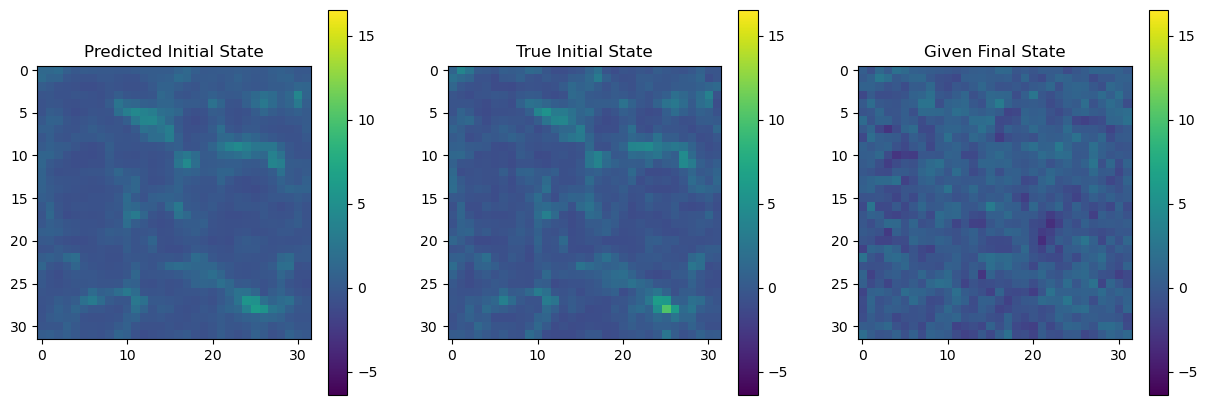

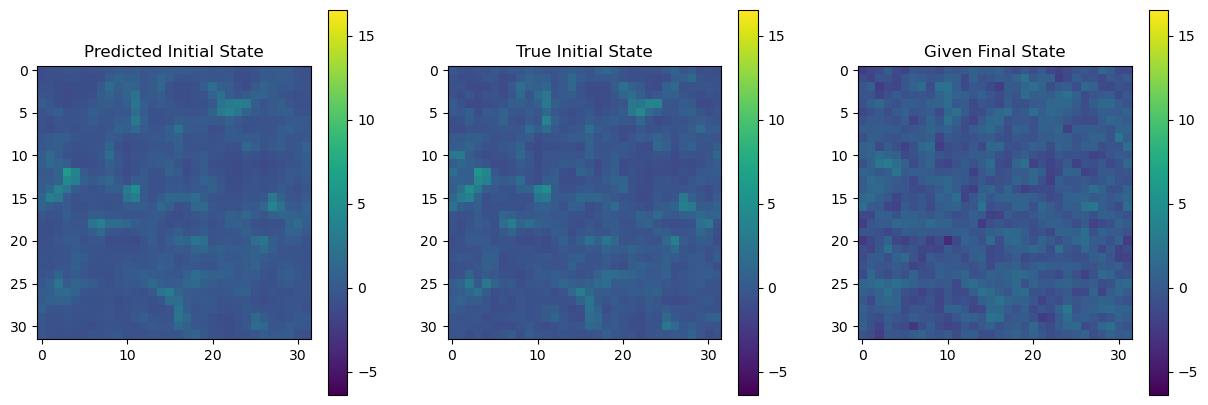

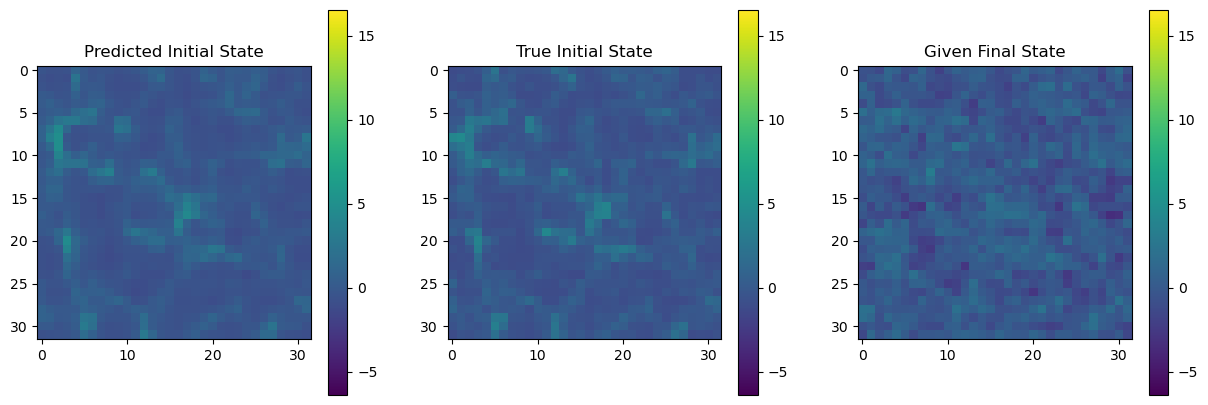

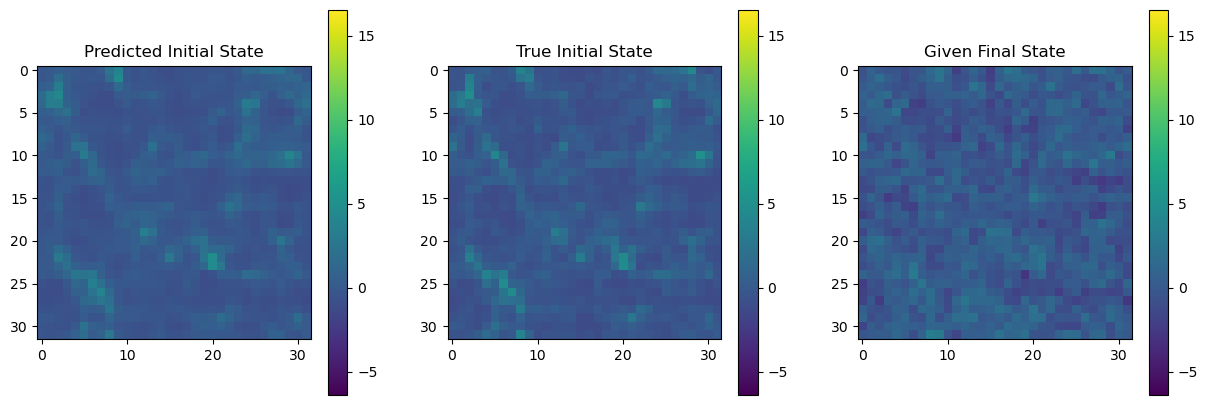

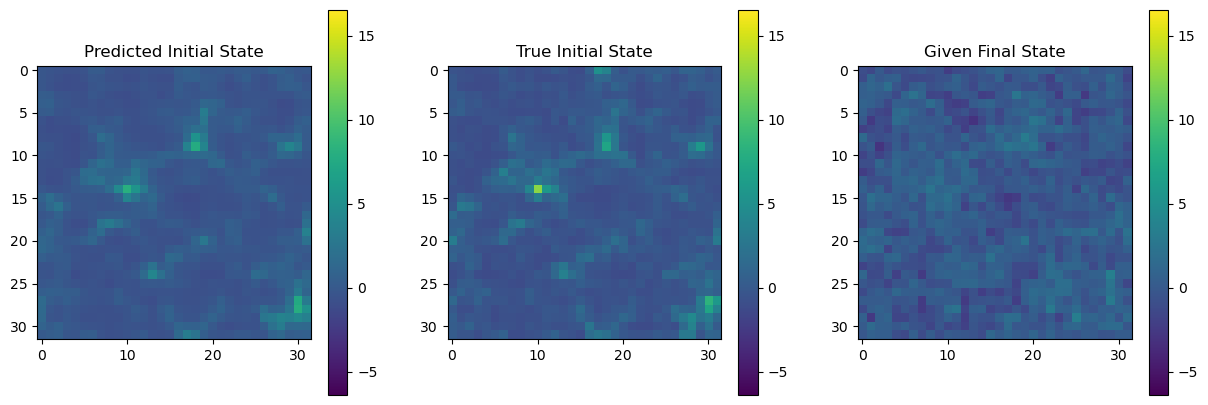

In [18]:
for test_index in range(5):  # Plot first 5 test cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Plot predicted initial state
    im = axs[0].imshow(predictions[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax,
                       cmap='viridis')
    axs[0].set_title('Predicted Initial State')
    fig.colorbar(im, ax=axs[0])

    # Plot true initial state
    im = axs[1].imshow(y_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax,
                       cmap='viridis')
    axs[1].set_title('True Initial State')
    fig.colorbar(im, ax=axs[1])

    # Plot given final state 
    im = axs[2].imshow(X_test[test_index].reshape(Ngrid, Ngrid, Ngrid)[Ngrid//2], 
                       vmin=vmin, 
                       vmax=vmax, 
                       cmap='viridis')
    axs[2].set_title('Given Final State')
    fig.colorbar(im, ax=axs[2])

    plt.show()

In [19]:
# calculating the error metrics
mse = mean_squared_error(y_test.flatten(), predictions.flatten())
mae = mean_absolute_error(y_test.flatten(), predictions.flatten())

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.17210792700590036
Mean Absolute Error (MAE): 0.28682557457519026


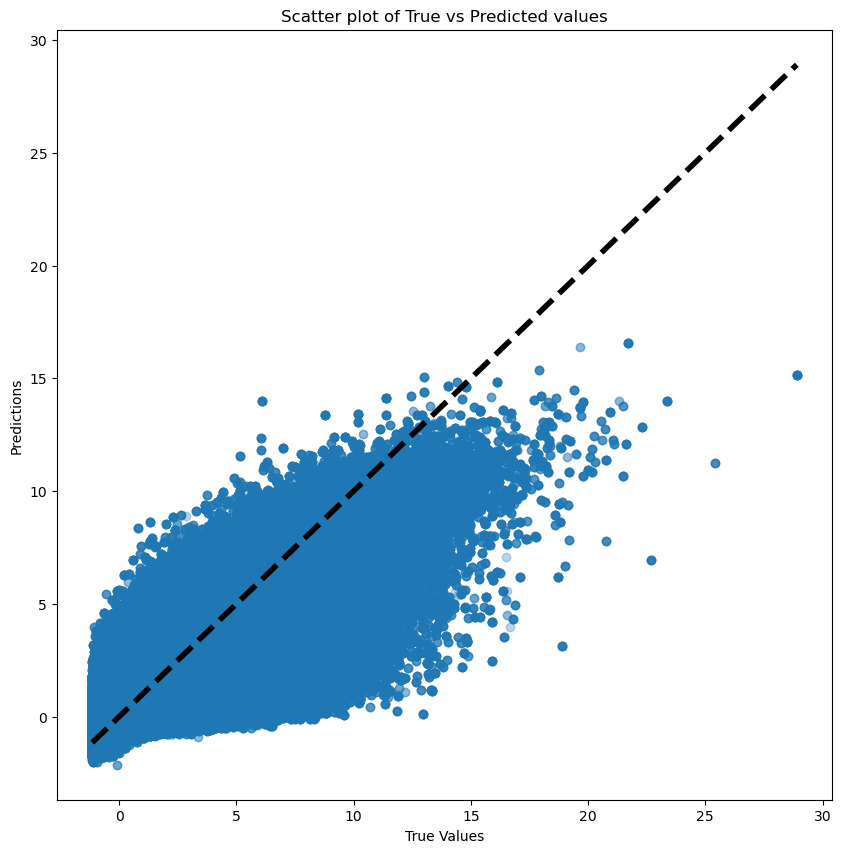

IOStream.flush timed out


In [20]:
plt.figure(figsize=(10,10))
plt.scatter(y_test.flatten(), predictions.flatten(), alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter plot of True vs Predicted values')
plt.show()

# Script Complete